# Example 4: Confidence intervals

## Retrieve data and obtain posterior log-rate map

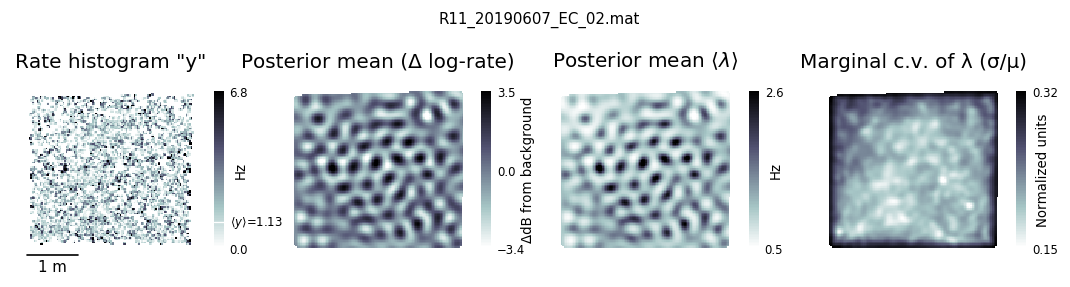

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from lgcpspatial.loaddata import Dataset
from lgcpspatial.lgcp2d   import DiagonalFourierLowrank
from lgcpspatial.lgcp2d   import coordinate_descent
from lgcpspatial.plot     import *

# Load dataset R11_20190607_EC_02
L        = 128 # Grid size for position bins
dataset  = 'R11_20190607_EC_02.mat'
fn       = '../example data/' + dataset
data     = Dataset.from_file(fn)
data.prepare(L)

# Infer using optimized parameters
# These parameters were computed in example 3
P        = 11.50 # Grid period
kv       = 0.103 # Log-rate prior covariance kernel peak variance (zero lag variance)
model    = DiagonalFourierLowrank(kv,P,data)
fit      = coordinate_descent(model,tol=1e-3)
low_rank_posterior_mean,posterior_variance,vfe = fit
inference_summary_plot(model,
    data.arena.mask,
    data.y,
    low_rank_posterior_mean,
    data.prior_mean,
    posterior_variance,
    data.position_sample_rate,
    L,
    data.scale,
    dataset);

## Confidence intervals via sampling or quadratic approximation

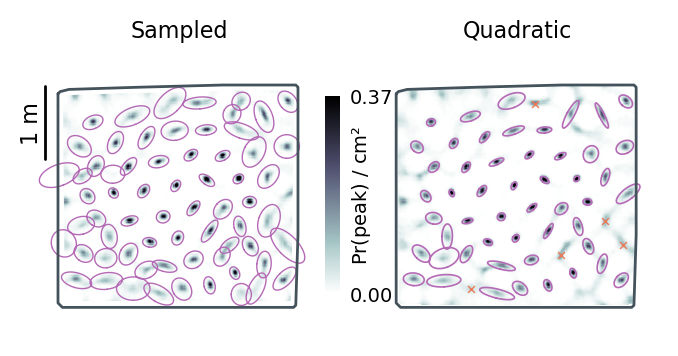

In [2]:
from lgcpspatial.posterior import SampledConfidence, QuadraticConfidence

resolution          = 2      # Upsampling resolution
exclusion_radius    = P/2.5  # Limit field radius/collisions
edge_radius         = P/2.5  # Drop peaks this close to edge
nsamples            = 1000   # Number of samples
localization_radius = P*0.75 # Drop peaks with confidence outside this radius

figure(figsize=(4,2),dpi=200)
subplot(121)
confidence = SampledConfidence(
    data,                 # Dataset
    model,                # Model
    fit,                  # Fitted result
    exclusion_radius,     # Use local maxima within this radius
    edge_radius,          # Delete close to edge
    resolution,           # Updampling
    nsamples,             # Samples to use
    height_threshold=0.7, # Amplitude threshold for peaks
    prpeak_threshold=0.7, # Fraction of samples peak must be present to include
    doplot=True,
    color=MAUVE,
    cmap='bone_r')
title('Sampled')
xlim(0,1); ylim(0,1);
plot(*data.arena.perimeter.T,lw=1,color=BLACK)

subplot(122)
# Confidence intervals directly from the posterior:
# A locally-quadratic approximation of the peak, disrupted 
# by the expected gradient of the posterior covariance, is 
# sufficient for getting confidence intervals for well-
# localized peaks. 
qconfidence = QuadraticConfidence(
    data,                 # Dataset
    model,                # Model
    fit,                  # Fitted result
    exclusion_radius,     # Peak neighorhood clearance
    localization_radius,  # Peak confidence threshold
    height_threshold=0.6, # Amplitude threshold for peaks
    edge_radius=edge_radius,
    doplot=True,
    draw_border=False)
title('Quadratic')
xlim(0,1); ylim(0,1);

vmax = ceil(percentile(
    confidence.samples.kde[confidence.arena.mask],99.9)*100)/100
imshow(confidence.samples.kde*confidence.arena.nanmask,
    extent=(0,1)*2,
    cmap='bone_r',
    vmin=0,
    vmax=vmax,
    origin='lower')
plot(*data.arena.perimeter.T,lw=1,color=BLACK)

## Figure 4d

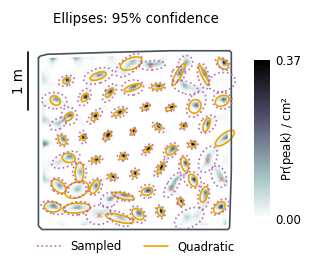

In [3]:
figure(figsize=(2.5,2.5),dpi=120)
confidence = SampledConfidence(
    data,                 # Dataset
    model,                # Model
    fit,                  # Fitted result
    exclusion_radius,     # Must be local max within radius
    edge_radius,          # Delete close to edge
    resolution,           # Updampling
    nsamples,             # Samples to use
    height_threshold=0.7, # Amplitude threshold for peaks
    prpeak_threshold=0.7, # Fraction of samples with peak
    doplot=True,
    color=MAUVE,
    linestyle=':',
    lw=1,
    label='Sampled',
    zorder = 100,
    cmap='bone_r')
# Confidence intervals directly from the posterior:
# A locally-quadratic approximation of the peak, disrupted 
# by the expected gradient of the posterior covariance, is 
# sufficient for getting confidence intervals for well-
# localized peaks. 
qconfidence = QuadraticConfidence(
    data,                 # Dataset
    model,                # Model
    fit,                  # Fitted result
    exclusion_radius,     # Peak neighorhood clearance
    localization_radius,  # Peak confidence threshold
    height_threshold=0.6, # Amplitude threshold for peaks
    edge_radius=edge_radius,
    doplot=True,
    color=OCHRE,
    lw=1,
    draw_border=False)
plot(*data.arena.perimeter.T,lw=1,color=BLACK)
legend(
    frameon = False,
    ncol = 2,
    loc='upper center',
    bbox_to_anchor=(0.5,0.1))
xlim(0,1); ylim(0,1);

savefig('fig4d.svg')

## Joint confidence ellipses (experimental) 

Text(0.5, 1.0, 'Quadratic (teal:joint, purple:independent)')

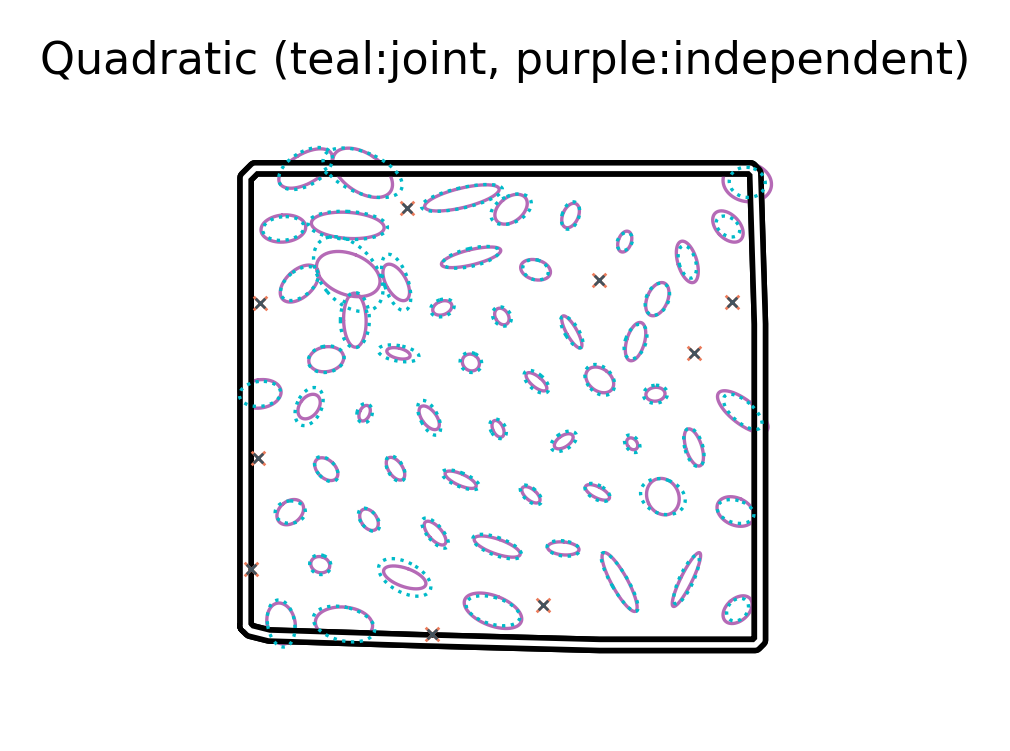

In [4]:
from lgcpspatial.posterior import QuadraticConfidenceJoint

figure(figsize=(2,2),dpi=400)
# Confidence intervals directly from the posterior:
# A locally-quadratic approximation of the peak, disrupted 
# by the expected gradient of the posterior covariance, is 
# sufficient for getting confidence intervals for well-
# localized peaks. 
confidence = QuadraticConfidence(
    data,                 # Dataset
    model,                # Model
    fit,                  # Fitted result
    exclusion_radius,     # Use local maxima within this radius
    localization_radius,  # Drop poorly-localized peaks
    height_threshold=0.5, # Amplitude threshold for peaks
    doplot=True)

# Confidence intervals directly from the posterior:
# A locally-quadratic approximation of the peak, disrupted 
# by the expected gradient of the posterior covariance, is 
# sufficient for getting confidence intervals for well-
# localized peaks. 
confidence = QuadraticConfidenceJoint(
    data,                 # Dataset
    model,                # Model
    fit,                  # Fitted result
    exclusion_radius,     # Use local maxima within this radius
    localization_radius,  # Drop poorly-localized peaks
    height_threshold=0.5, # Amplitude threshold for peaks
    doplot=True,
    color=TEAL,linestyle=':')
title('Quadratic (teal:joint, purple:independent)')